This tutorial provides a simple yet powerful introduction to the `ncpi` library. It walks through the core workflow and highlights the library’s main functionalities, demonstrating its potential through this practical example. In this tutorial, we define a simplified toy simulator that generates spike trains. For an example using a real spiking simulator, see the tutorial *Forward Modelling of Neural Activity*. We transform spikes into field potentials using a field potential proxy and extract the `catch22` feature set from the simulated data. Finally,we split the data into training and test sets to evaluate the capacity of an `MLPRegressor` inverse model to recover the original simulation model parameters.

First, we define a simplified neural simulator that generates synthetic spike trains. The simulator models synaptic-like dynamics by convolving random input signals with an exponential kernel, producing smoothed spike probability traces. Binary spike trains are then sampled based on these probabilities. The decay rate of the kernel is controlled by the input parameter `θ`, which acts as the only model parameter.

In [1]:
import numpy as np

def simulator(θ, n_neurons=50, sim_time=2000, sampling_rate=100):
    """
    Simulates spike trains modulated by a synaptic-like process.

    This function generates synthetic neural spike trains by first creating
    a random input signal for each neuron and convolving it with an exponential
    kernel that mimics synaptic dynamics. The result is a smooth, temporally
    correlated signal interpreted as the probability of spiking at each time step.

    Parameters
    ----------
    θ : float
        Controls the exponential decay of the synaptic kernel.
    n_neurons: int, optional
        Number of neurons to simulate. Default is 50.
    sim_time: int, optional
        Length of the simulation in time points. Default is 2000.
    sampling_rate: int, optional
        Sampling rate in Hz (or time points per second). Default is 100.

    Returns
    -------
    spikes : ndarray of shape (n_neurons, sim_time)
        Binary array representing spikes (1s) and no spikes (0s) for each neuron over time.
    exp_kernel : ndarray
        The exponential kernel used for convolution.
    """
    spikes = np.zeros((n_neurons, sim_time))

    # Define exponential kernel to model synaptic integration
    tau = sampling_rate * (θ + 0.01)
    t_kernel = np.arange(int(sampling_rate * 4))  # Kernel length of 4 times the sampling rate
    exp_kernel = np.exp(-t_kernel / tau)

    for neuron in range(n_neurons):
        # Generate random input signal for this neuron
        raw_input = np.random.rand(sim_time)

        # Convolve input with synaptic kernel to create smooth modulated signal
        modulated = np.convolve(raw_input, exp_kernel, mode='same')

        # Normalize modulated signal to [0, 1]
        modulated -= modulated.min()
        modulated /= modulated.max()

        # Apply a threshold
        spike_probs = modulated - 0.9

        # Sample binary spikes based on spike probabilities
        spikes[neuron] = np.random.rand(sim_time) < spike_probs

    return spikes, exp_kernel

Let’s plot some spiking activity across different `theta` parameter combinations.

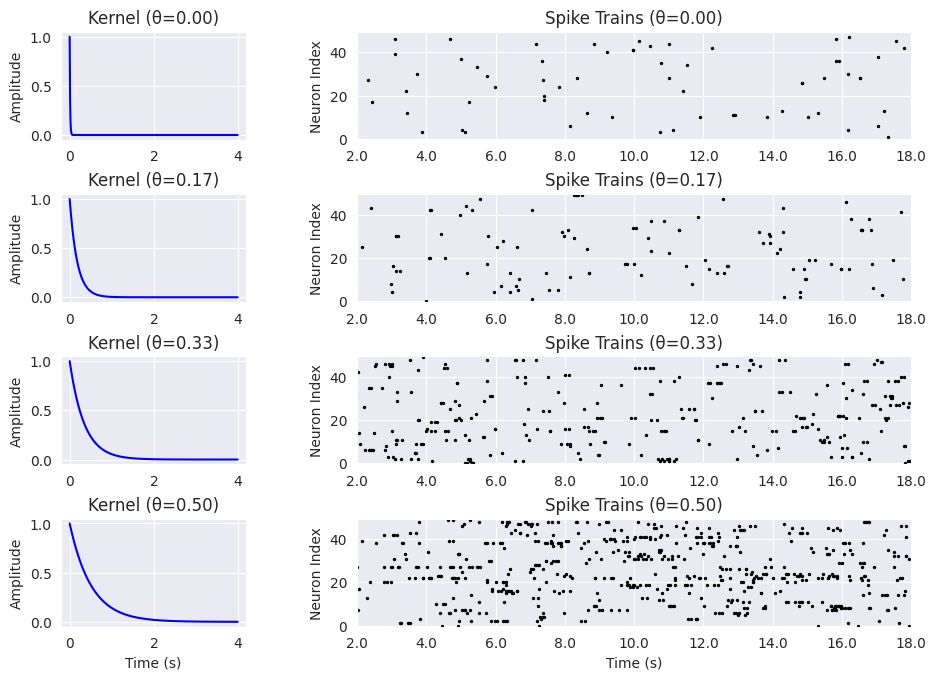

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Generate some θs
θ = np.linspace(0, 0.5, 4)

# Simulate spike trains for each parameter
simulations = [simulator(theta) for theta in θ]

# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(len(θ), 2, width_ratios=[1, 3], wspace=0.3)

for i, (theta, sim_data) in enumerate(zip(θ, simulations)):
    spikes, exp_kernel = sim_data

    # Plot the exponential kernel
    ax_kernel = fig.add_subplot(gs[i, 0])
    ax_kernel.plot(np.arange(len(exp_kernel)) / 100, exp_kernel, color='blue')
    ax_kernel.set_title(f'Kernel (θ={theta:.2f})')
    if i == len(θ) - 1:
        ax_kernel.set_xlabel('Time (s)')
    ax_kernel.set_ylabel('Amplitude')

    # Plot the spike trains as a scatter plot for all 50 neurons
    ax_spike = fig.add_subplot(gs[i, 1])
    for neuron_idx, neuron_spikes in enumerate(spikes):
        spike_times = np.where(neuron_spikes == 1)[0]  # Get spike times (indices where spikes occur)
        ax_spike.scatter(spike_times, [neuron_idx] * len(spike_times), color='black', s=2)

    ax_spike.set_title(f'Spike Trains (θ={theta:.2f})')
    ax_spike.set_ylabel('Neuron Index')
    if i == len(θ) - 1:
        ax_spike.set_xlabel('Time (s)')
    ax_spike.set_xticks(range(200, 1801, 200))
    ax_spike.set_xticklabels([f"{t/100:.1f}" for t in range(200, 1801, 200)])
    ax_spike.set_xlim(200, 1800)
    ax_spike.set_ylim(-0.5, 49.5)  # Adjust y-axis limits to fit 50 neurons

# Adjust spacing between subplots
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.3, hspace=0.5)

plt.show()

Here, we generate a dataset by simulating spike trains for different values of the parameter `θ`. For each simulation, we calculate firing rates and a field potential proxy, which will be used later for training and testing our model.

In [3]:
import ncpi

# Set simulation parameters
n_neurons = 50           # Number of neurons in each simulated recording
sim_time = 2000          # Total number of time points per sample
sampling_rate = 100      # Sampling rate in Hz
n_samples = 1000        # Total number of samples (combined training + test set)

# Preallocate arrays for storing simulation output
sim_data = {
    'X': np.zeros((n_samples, int((sim_time + sampling_rate - 1) / sampling_rate))),
    'θ': np.zeros((n_samples, 1))
}

# Create the simulation dataset
for sample in range(n_samples):
    # print(f'Creating sample {sample + 1} of {n_samples}', end='\r', flush=True)
    # Generate a random parameter θ
    θ = np.random.uniform(0, 1)

    # Simulate the spike train
    spikes, exp_kernel = simulator(θ, sampling_rate=sampling_rate,
                                      n_neurons=n_neurons,
                                      sim_time=sim_time)

    # Compute firing rates
    fr = [[np.sum(spikes[ii, jj * sampling_rate:(jj + 1) * sampling_rate])
           for jj in range(sim_data['X'].shape[1])]
           for ii in range(spikes.shape[0])]

    # Create a FieldPotential object
    fp = ncpi.FieldPotential(kernel = False)

    # Get the field potential proxy
    proxy = fp.compute_proxy(method = 'FR', sim_data = {'FR': fr}, sim_step = None)

    # Save simulation data
    sim_data['X'][sample, :] = proxy
    sim_data['θ'][sample, 0] = θ

Next, we reshape the `θ` array if needed and extract features from the simulated data using the `catch22` feature set. These features will help us train the model to predict `θ`.

In [4]:
import pandas as pd

# If sim_data['θ'] is a 2D array with one column, reshape it to a 1D array
if sim_data['θ'].shape[1] == 1:
    sim_data['θ'] = np.reshape(sim_data['θ'], (-1,))

# Compute features
df = pd.DataFrame({'Data': sim_data['X'].tolist()})
features = ncpi.Features(method='catch22')
df = features.compute_features(df)

Computing features: 100%|██████████| 334/334 [00:02<00:00, 143.06it/s]


Let’s explore how the 22 `catch22` features evolve as `θ` changes.

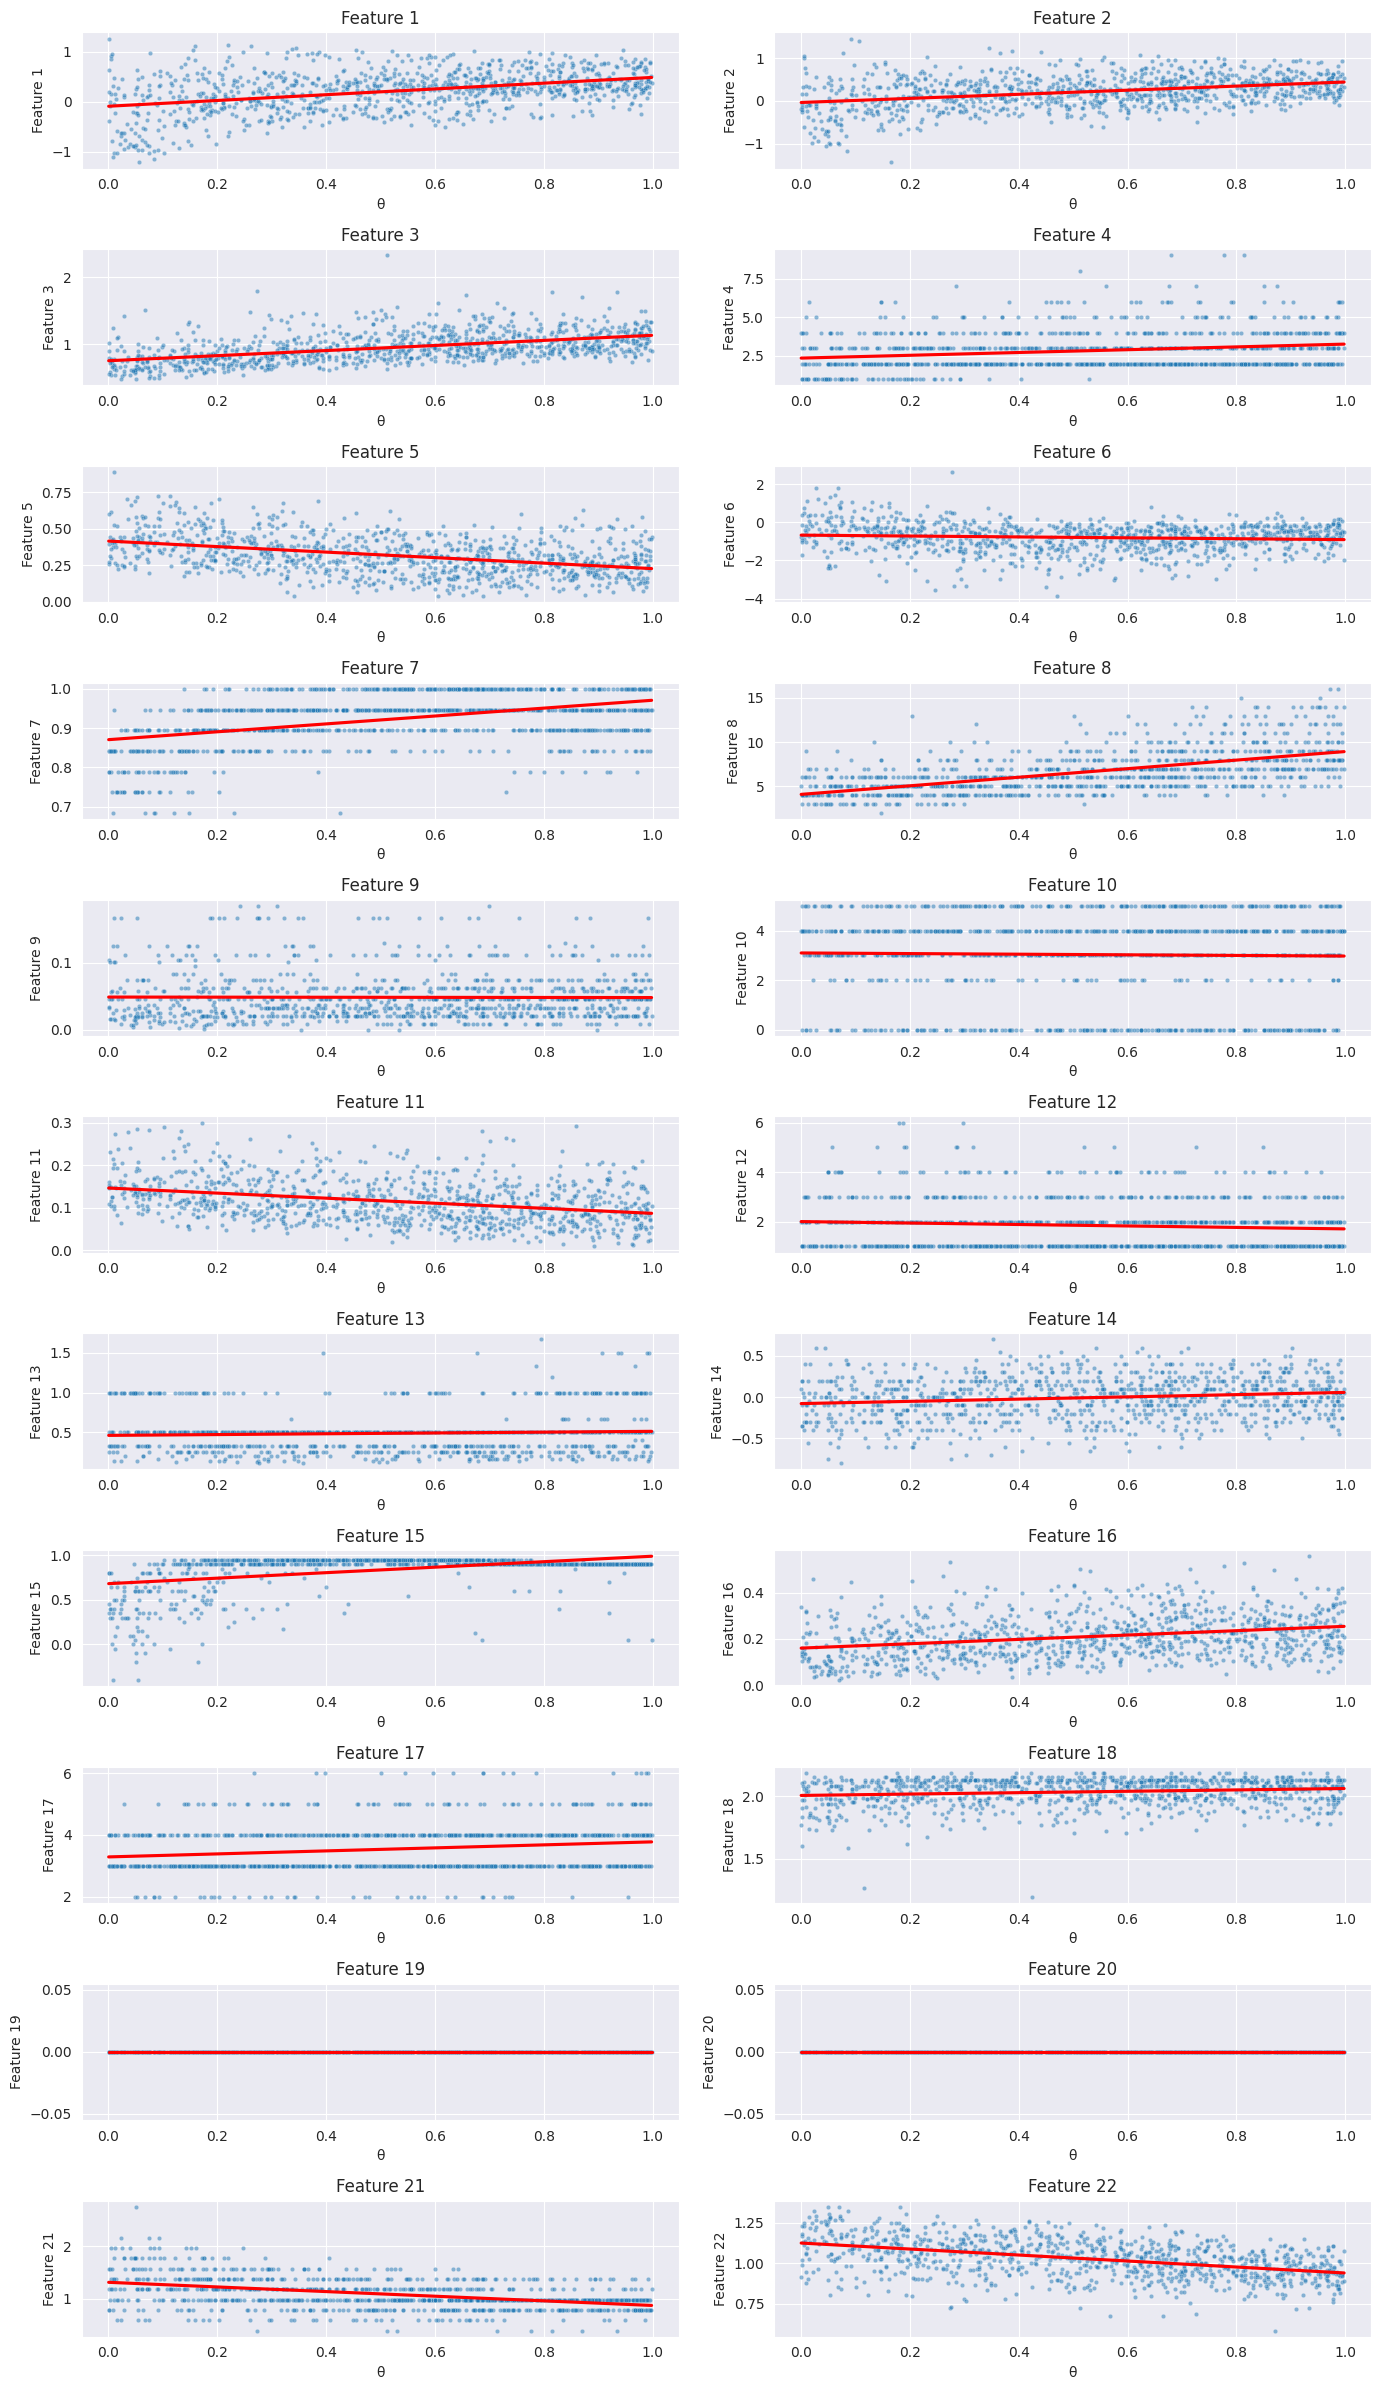

In [5]:
import seaborn as sns

# Extract features and θ values
features = np.array(df['Features'].tolist())  # Shape: (n_samples, 22)
theta_values = sim_data['θ']  # Shape: (n_samples,)

# Create a DataFrame for easier plotting with Seaborn
plot_data = pd.DataFrame(features, columns=[f'Feature {i+1}' for i in range(22)])
plot_data['θ'] = theta_values

# Create a figure with subplots for each feature
fig, axes = plt.subplots(11, 2, figsize=(14, 24))  # 11 rows, 2 columns for 22 features
axes = axes.flatten()  # Flatten axes for easy iteration

for i, ax in enumerate(axes):
    if i < 22:  # Plot only for the 22 features
        sns.scatterplot(x='θ', y=f'Feature {i+1}', data=plot_data, ax=ax, alpha=0.5, s=10)
        sns.regplot(x='θ', y=f'Feature {i+1}', data=plot_data, ax=ax, scatter=False, color='red', ci=None)
        ax.set_title(f'Feature {i+1}')
    else:
        ax.axis('off')  # Turn off unused subplots

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Now, we split the data into 90% for training and 10% for testing. The training data is used to teach the model, while the test data evaluates how well it performs. If you’re working with real data, the test set could be replaced with actual experimental data to predict changes in parameters.

In [6]:
# Split simulation data into 90% training and 10% test data
indices = np.arange(n_samples)
np.random.shuffle(indices)
split = int(0.9 * len(indices))
train_indices = indices[:split]
test_indices = indices[split:]

X_train = np.array(df.iloc[train_indices].drop(columns=['Data'])['Features'].tolist())
X_test = np.array(df.iloc[test_indices].drop(columns=['Data'])['Features'].tolist())
θ_train = np.array(sim_data['θ'][train_indices])
θ_test = np.array(sim_data['θ'][test_indices])

Here, we set up and train the model. The model learns to predict the parameter `θ` based on the features we extracted earlier.

In [7]:
# Create the inference object and add simulation data
inference = ncpi.Inference(model='MLPRegressor',
                           hyperparams={'hidden_layer_sizes': (200,200,200),
                                        'max_iter': 200,
                                        'tol': 0.0001,
                                        'n_iter_no_change': 10})
inference.add_simulation_data(X_train, θ_train)

# Train the model
inference.train(param_grid=None)

Let’s evaluate how well the model performs! Using the test data, we generate predictions and compare them against the true values of `θ`. Ideally, the predicted points should fall along the red dashed line, which represents perfect agreement between predictions and true values. Feel free to experiment with different hyperparameters when creating the inference object to observe how the model’s accuracy changes.

Computing predictions: 100%|██████████| 34/34 [00:02<00:00, 15.34it/s]


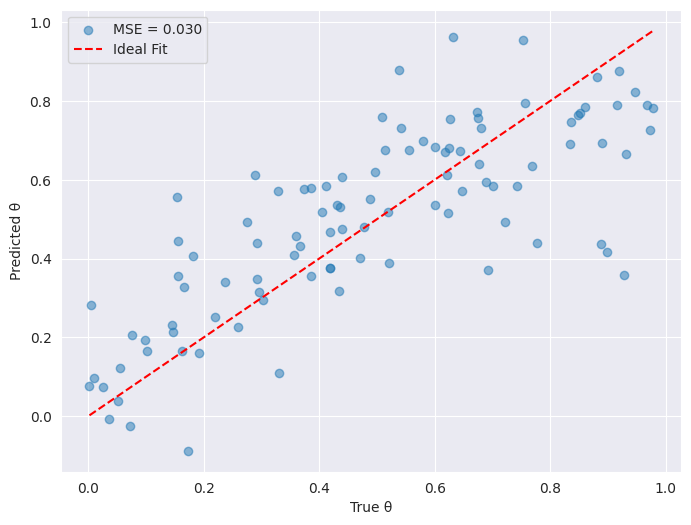

In [8]:
from sklearn.metrics import mean_squared_error

# Evaluate the model using the test data
predictions = inference.predict(X_test)

# Calculate MSE
mse = mean_squared_error(θ_test, predictions)

# Plot real vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(θ_test, predictions, alpha=0.5, label=f'MSE = {mse:.3f}')
plt.plot([θ_test.min(), θ_test.max()], [θ_test.min(), θ_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('True θ')
plt.ylabel('Predicted θ')
plt.legend()
plt.show()